In [ ]:
# Check this colab for code that will actually run
# https://colab.research.google.com/drive/1IKl2bBbs_63Rccd2mv364_gHyxBJV5A8?usp=sharing

In [1]:
# Things for Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
cd drive/MyDrive/MacAI

/content/drive/MyDrive/MacAI


In [9]:
# Install a dependency
!pip install torchsummaryX

In [10]:
# Just stuff for TPUs, but didn't seem to work
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py 

In [17]:
from lib import medzoo
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib import losses3D
from torch.utils.checkpoint import checkpoint_sequential
from skimage import transform
import nibabel as nb

using_TPU = False
if using_TPU:
  import torch_xla
  import torch_xla.core.xla_model as xm

In [18]:
# Get bounding box of a 3D image, shamelessly stolen from the following link.
# There's probably actually a way to rotate an image to fit into the smallest
# bounding box possible based on scipy.optimize, but whatever
# https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def bbox2_3D(img):

    r = np.any(img, axis=(1, 2))
    c = np.any(img, axis=(0, 2))
    z = np.any(img, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]

    return rmin, rmax, cmin, cmax, zmin, zmax

Space conserving factor of 2.083 by brain masking and cropping


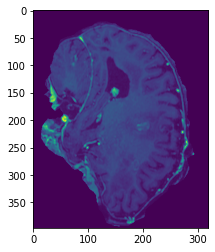

In [19]:
# Load a file and apply brain mask (obtained using FSMRIB library)
# then crop image

seg = nb.load('files/segmentation.nii.gz').get_fdata()
t1 = nb.load('files/T1.nii').get_fdata()/1000
brain_mask = nb.load('files/T1_mask.nii.gz').get_fdata()
t1[brain_mask==0] = 0
xmin, xmax, ymin, ymax, zmin, zmax = bbox2_3D(t1)
t1 = t1[xmin:xmax, ymin:ymax]#, zmin:zmax]
seg = seg[xmin:xmax, ymin:ymax]#, zmin:zmax]
plt.imshow(t1[220])

print('Space conserving factor of ' + str(round((512*512*320)/np.prod(t1.shape), 4)) + ' by brain masking and cropping')

In [20]:
# This shouldn't be a thing in the final model, but U-net complains
# if each dimension isn't divisible by something like 16 or 32
# This should be easily fixable by changing the padding in the UNet3D
t1 = transform.resize(t1, [320, 400, 320])
seg = transform.resize(seg, [320, 400, 320])

In [21]:
# More code shamelessly stolen from stack overflow, makes pytorch use GPU

if using_TPU:
  device = xm.xla_device()
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  if device.type != 'cpu':
      print(torch.cuda.get_device_name(0))
  print('Allocated:', round(torch.cuda.memory_allocated()/1024**3,1), 'GB')
  print('Reserved:', round(torch.cuda.memory_reserved()/1024**3,1), 'GB')
  
print('Using device:', device)
print()


Tesla T4
Allocated: 0.0 GB
Reserved: 0.0 GB
Using device: cuda



In [22]:
# So (a single) raw image series are about 8-16x too big to fit using batch size 1
# The optimizations that I've identified here that we need are:
# 16-bit precision (or less, but Pytorch doesn't support it): Reduction by factor 2
# Brain masking and cropping the brain - in this case, reduction by a factor of 2
# Making the network have 2x less filters works, I guess the true amount of reduction was less than 16x

# Next steps
# Gradient checkpointing thought to reduce it by another 5-10x, but for some reason
# checkpoint_sequential is weird
# Also, you'd still have to reduce the high number of image channels to one or two channels

t1_tensor = torch.Tensor(np.expand_dims(np.expand_dims(t1, axis=0), axis=0)).half().to(device)
seg_tensor = torch.Tensor(np.expand_dims(np.expand_dims(seg, axis=0), axis=0)).half().to(device)


In [23]:
print(t1_tensor.shape)

unet = medzoo.UNet3D(1,1, base_n_filter=4).to(device) 
unet.half()
#modules = [module for k, module in unet._modules.items()]

#output = checkpoint_sequential(modules, 6, t1_tensor)
print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')

optimizer = torch.optim.Adam(unet.parameters()) 
# Pixel-wise CE gives some weird shape error with "weights"

loss_function = losses3D.WeightedSmoothL1Loss()
for i in range(1):
  outputs = unet(t1_tensor)
  loss = loss_function(outputs, seg_tensor)
  print(loss)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

torch.Size([1, 1, 320, 400, 320])
Allocated: 0.2 GB
tensor(0.2390, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>)


In [24]:
# Wait this experiment makes no sense
#import sys
#import os
#models = [
#medzoo.Unet3D.UNet3D(1, 1),
#medzoo.HighResNet3D(1, 1),
#medzoo.DenseVoxelNet(1,1 ),
#medzoo.ResNet3D_VAE.ResNet3dVAE(1,1 ),
#medzoo.Vnet.VNetLight(1,1),
#medzoo.SkipDenseNet3D.SkipDenseNet3D(1,1)
#]

#if not os.path.exists('model_sizes'):
#  os.mkdir('model_sizes')
#types = ['Unet', 'ResNet', 'VoxelNet', 'ResNetVAE','VNet']
#for i, model in enumerate(models):
 # model.eval()
#  torch.save(model.state_dict(), 'model_sizes/'+types[i]+'.pt')



In [25]:
# Every single network crashes even using 1 series
# Also some might have problems with image sizes that aren't multiples of 2, idk


# Crashes list
# Unet3D.UNet3D(1, 1)
# medzoo.HighResNet3D(1, 1)
# medzoo.DenseVoxelNet(1,1 )
# medzoo.ResNet3D_VAE.ResNet3dVAE(1,1 )
# VNetLight
# SkipDenseNet3D
# doesn't work for 1 channel
# medzoo.HyperDenseNet_2Mod(1, 1)
# medzoo.ResNet3DMedNet.ResNetMed3D(1,1)
# still crashes with TPU which has 64 GB HBM

